# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'augmented_mlp_window_important_plus10'
x_important = pd.read_csv('./data/features-important-names.csv').column_name.to_list()
x_important

x_cts   = variables.x_cts_window + [
    'net_charge_all_around_target_ser_thr'
]
x_cat   = variables.x_cat_window + [
    'number_of_arg',
    'number_of_g',
    'number_of_ser',
    'number_of_thr',
    'number_of_v'
]
y_label = variables.y_label

print(f"{len(x_cts)} x_cts:")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

3 x_cts:
17 x_cat: ['SEQ', 'nS/nT', 'nAli', 'nPos', 'phi_psi', 'SS', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5', 'number_of_arg', 'number_of_g', 'number_of_ser', 'number_of_thr', 'number_of_v']
1 y_label: ['positivity']
dummy x shape: (8910, 192)
dummy y shape: (8910, 1)


{0: 'Proline',
 1: 'flexibility',
 2: 'net_charge_all_around_target_ser_thr',
 3: 'SEQ_S',
 4: 'SEQ_T',
 5: 'nS/nT_1',
 6: 'nS/nT_2',
 7: 'nS/nT_3',
 8: 'nS/nT_4',
 9: 'nS/nT_5',
 10: 'nS/nT_6',
 11: 'nS/nT_7',
 12: 'nS/nT_8',
 13: 'nS/nT_9',
 14: 'nS/nT_10',
 15: 'nS/nT_11',
 16: 'nS/nT_12',
 17: 'nS/nT_13',
 18: 'nS/nT_14',
 19: 'nS/nT_15',
 20: 'nAli_0',
 21: 'nAli_1',
 22: 'nAli_2',
 23: 'nAli_3',
 24: 'nPos_0',
 25: 'nPos_1',
 26: 'nPos_2',
 27: 'nPos_3',
 28: 'phi_psi_alpha',
 29: 'phi_psi_beta',
 30: 'phi_psi_other',
 31: 'SS_C',
 32: 'SS_E',
 33: 'SS_H',
 34: 'side_-1_cycle',
 35: 'side_-1_gly',
 36: 'side_-1_long',
 37: 'side_-1_normal',
 38: 'side_-1_pro',
 39: 'side_-1_small',
 40: 'side_-1_very_small',
 41: 'side_1_None',
 42: 'side_1_cycle',
 43: 'side_1_gly',
 44: 'side_1_long',
 45: 'side_1_normal',
 46: 'side_1_pro',
 47: 'side_1_small',
 48: 'side_1_very_small',
 49: 'side_2_None',
 50: 'side_2_cycle',
 51: 'side_2_gly',
 52: 'side_2_long',
 53: 'side_2_normal',
 54: '

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 192) (13960, 1)
Epoch 1/10000
437/437 - 2s - loss: 0.5743 - accuracy: 0.6950 - val_loss: 0.4807 - val_accuracy: 0.7581 - 2s/epoch - 5ms/step
Epoch 2/10000
437/437 - 2s - loss: 0.5350 - accuracy: 0.7311 - val_loss: 0.6306 - val_accuracy: 0.6655 - 2s/epoch - 4ms/step
Epoch 3/10000
437/437 - 1s - loss: 0.5266 - accuracy: 0.7333 - val_loss: 0.5444 - val_accuracy: 0.7177 - 1s/epoch - 3ms/step
Epoch 4/10000
437/437 - 1s - loss: 0.5213 - accuracy: 0.7360 - val_loss: 0.5029 - val_accuracy: 0.7374 - 946ms/epoch - 2ms/step
Epoch 5/10000
437/437 - 1s - loss: 0.5213 - accuracy: 0.7394 - val_loss: 0.4897 - val_accuracy: 0.7486 - 864ms/epoch - 2ms/step
Epoch 6/10000
437/437 - 1s - loss: 0.5180 - accuracy: 0.7415 - val_loss: 0.5812 - val_accuracy: 0.6947 - 895ms/epoch - 2ms/step
Epoch 7/10000
43

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,7,0.735,0.515411,0.427828,0.427828,78.84,5.03,51.35,9.16
1,5,100,38,1.201,0.491880,0.474684,0.474684,75.98,3.78,43.24,6.96
2,5,100,12,0.717,0.491426,0.443647,0.443647,78.23,3.69,37.84,6.73
3,5,100,39,1.193,0.490348,0.461521,0.461521,77.44,4.26,45.95,7.80
4,5,100,3,0.606,0.510484,0.486142,0.486142,75.31,3.68,43.24,6.78
5,5,100,26,1.021,0.488445,0.464760,0.464760,77.05,3.27,35.14,5.98
6,5,100,7,0.669,0.492244,0.415230,0.415230,80.53,3.59,32.43,6.47
7,5,100,3,0.574,0.476068,0.382668,0.382668,82.38,3.05,24.32,5.42
8,5,100,3,0.657,0.526304,0.435141,0.435141,79.85,3.74,35.14,6.75
9,5,100,37,1.244,0.495804,0.479502,0.479502,74.64,3.58,43.24,6.61



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0099778270509978
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_1of20.h5


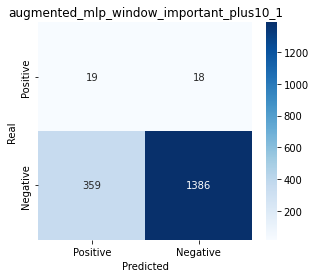

accuracy  : 78.84
precision : [98.72  5.03]
recall    : [79.43 51.35]
f1_score  : [88.03  9.16]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0160334676319485
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_2of20.h5


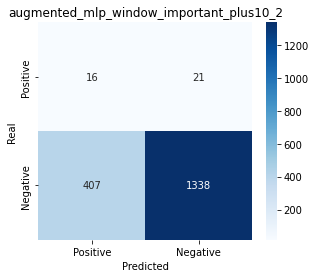

accuracy  : 75.98
precision : [98.45  3.78]
recall    : [76.68 43.24]
f1_score  : [86.21  6.96]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_3of20.h5


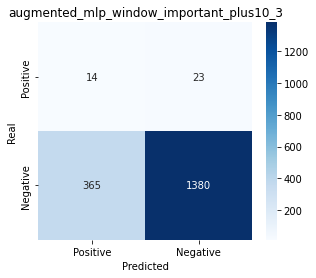

accuracy  : 78.23
precision : [98.36  3.69]
recall    : [79.08 37.84]
f1_score  : [87.67  6.73]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_4of20.h5


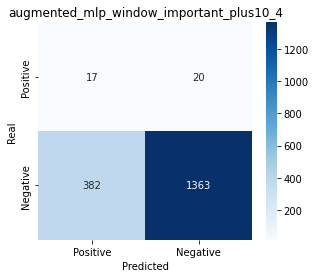

accuracy  : 77.44
precision : [98.55  4.26]
recall    : [78.11 45.95]
f1_score  : [87.15  7.8 ]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.037974683544303806 1.0103567318757194
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_5of20.h5


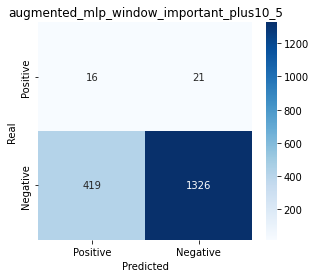

accuracy  : 75.31
precision : [98.44  3.68]
recall    : [75.99 43.24]
f1_score  : [85.77  6.78]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_6of20.h5


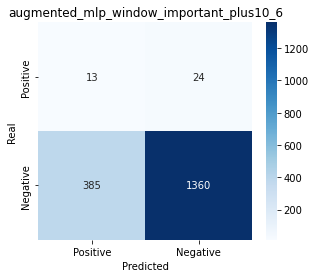

accuracy  : 77.05
precision : [98.27  3.27]
recall    : [77.94 35.14]
f1_score  : [86.93  5.98]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_7of20.h5


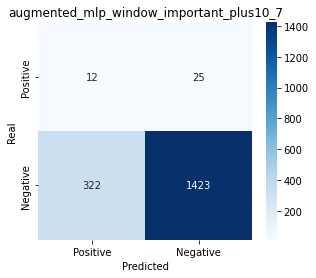

accuracy  : 80.53
precision : [98.27  3.59]
recall    : [81.55 32.43]
f1_score  : [89.13  6.47]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.070510462046319 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_8of20.h5


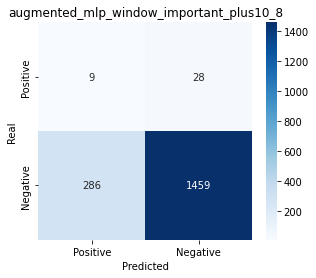

accuracy  : 82.38
precision : [98.12  3.05]
recall    : [83.61 24.32]
f1_score  : [90.28  5.42]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_9of20.h5


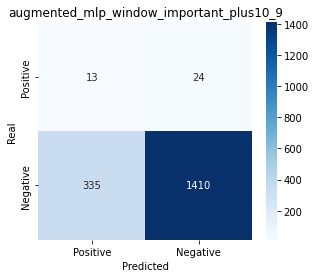

accuracy  : 79.85
precision : [98.33  3.74]
recall    : [80.8  35.14]
f1_score  : [88.71  6.75]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_10of20.h5


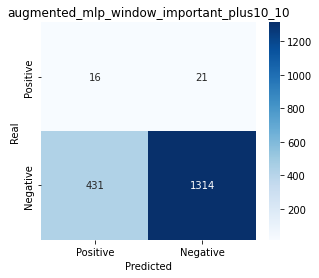

accuracy  : 74.64
precision : [98.43  3.58]
recall    : [75.3  43.24]
f1_score  : [85.32  6.61]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_11of20.h5


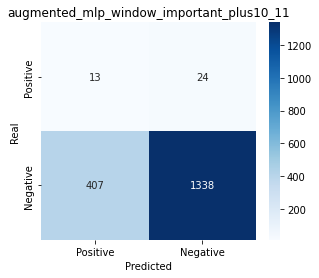

accuracy  : 75.81
precision : [98.24  3.1 ]
recall    : [76.68 35.14]
f1_score  : [86.13  5.69]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_12of20.h5


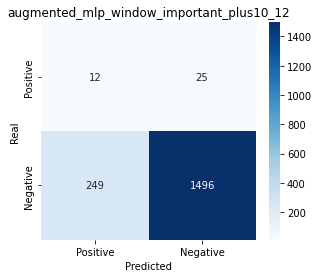

accuracy  : 84.61999999999999
precision : [98.36  4.6 ]
recall    : [85.73 32.43]
f1_score  : [91.61  8.05]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0167410714285714
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_13of20.h5


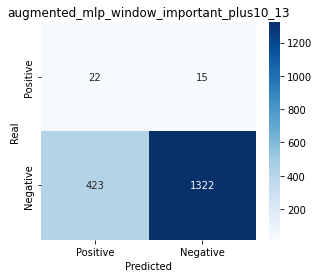

accuracy  : 75.42
precision : [98.88  4.94]
recall    : [75.76 59.46]
f1_score  : [85.79  9.13]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_14of20.h5


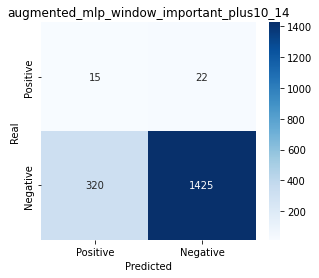

accuracy  : 80.81
precision : [98.48  4.48]
recall    : [81.66 40.54]
f1_score  : [89.29  8.06]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.07172207301241748 1.0171834211680892
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_15of20.h5


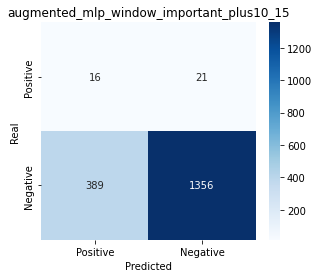

accuracy  : 76.99000000000001
precision : [98.47  3.95]
recall    : [77.71 43.24]
f1_score  : [86.87  7.24]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_16of20.h5


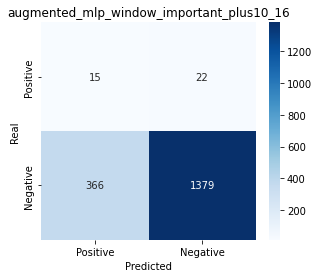

accuracy  : 78.23
precision : [98.43  3.94]
recall    : [79.03 40.54]
f1_score  : [87.67  7.18]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_17of20.h5


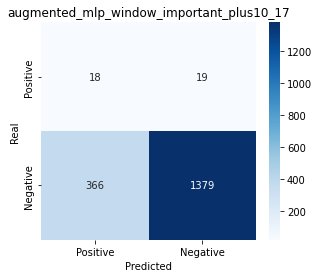

accuracy  : 78.4
precision : [98.64  4.69]
recall    : [79.03 48.65]
f1_score  : [87.75  8.55]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.032036613272311214 1.0102974828375288
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_18of20.h5


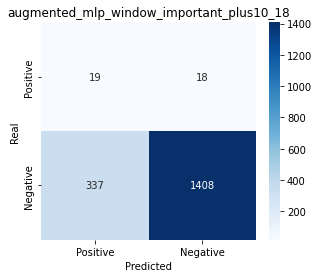

accuracy  : 80.08
precision : [98.74  5.34]
recall    : [80.69 51.35]
f1_score  : [88.8   9.67]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: -0.03758542141230069 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_19of20.h5


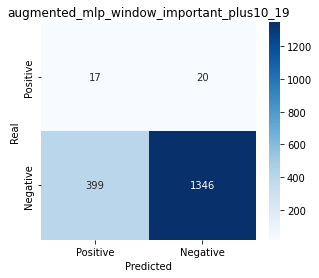

accuracy  : 76.49000000000001
precision : [98.54  4.09]
recall    : [77.13 45.95]
f1_score  : [86.53  7.51]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 192) (7128, 1)
check scale: 0.0 1.0

test: (1782, 192) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 192) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_plus10_5_100_cv_20of20.h5


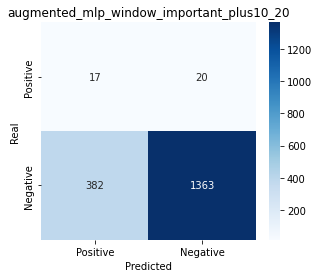

accuracy  : 77.44
precision : [98.55  4.26]
recall    : [78.11 45.95]
f1_score  : [87.15  7.8 ]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])